<a href="https://colab.research.google.com/github/NataliaGon/kpi/blob/intelligent-data-analysis/Lab2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Зниження розмірності і візуалізація даних

In [ ]:
import os
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from io import BytesIO
from PIL import Image
import requests

import kagglehub


from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    cross_val_score,
    GridSearchCV,
)
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score,
)

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.cluster import KMeans



In [ ]:
path = kagglehub.dataset_download("atharvasoundankar/global-cybersecurity-threats-2015-2024")

print("Path to dataset files:", path)
df = pd.read_csv(os.path.join(path, "Global_Cybersecurity_Threats_2015-2024.csv"))

100%|██████████| 47.0k/47.0k [00:00<00:00, 18.7MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/atharvasoundankar/global-cybersecurity-threats-2015-2024/versions/1


In [ ]:
TGT = "Incident Resolution Time (in Hours)"
DROP_COLS = ["Year"]

# Equal-frequency bins (3 classes): short / medium / long
y = pd.qcut(
    df[TGT],
    q=3,
    labels=["short","medium","long"],
)

print("Overall class counts:\n", y.value_counts())

X = df.drop(columns=DROP_COLS + [TGT])

X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Preprocessing pipeline (numeric: impute+scale; categorical: impute+one-hot)
num_cols = X_train_raw.select_dtypes(include=["number"]).columns.tolist()

X_num = X_train_raw[num_cols]

cat_cols = [c for c in X_train_raw.columns if c not in num_cols]


num_pipe = Pipeline([
    ("imp", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

cat_pipe = Pipeline([
    ("imp", SimpleImputer(strategy="most_frequent")),
    ("ohe", ohe)
])

preprocessor = ColumnTransformer(
    [("num", num_pipe, num_cols),
     ("cat", cat_pipe, cat_cols)]
)


print(f"\n================================")
print("Train class distribution:\n", y_train.value_counts(normalize=True))
print(f"\n================================")
print("Test  class distribution:\n", y_test.value_counts(normalize=True))

Overall class counts:
 Incident Resolution Time (in Hours)
short     1026
medium     991
long       983
Name: count, dtype: int64

Train class distribution:
 Incident Resolution Time (in Hours)
short     0.342083
medium    0.330417
long      0.327500
Name: proportion, dtype: float64

Test  class distribution:
 Incident Resolution Time (in Hours)
short     0.341667
medium    0.330000
long      0.328333
Name: proportion, dtype: float64


In [ ]:

preprocessor = ColumnTransformer(
    [("num", num_pipe, num_cols),
     ("cat", cat_pipe, cat_cols)]
)


pipe_knn = Pipeline([("prep", preprocessor), ("clf", KNeighborsClassifier(n_neighbors=3, weights='distance',p=2 ))])


pipe_pca_knn = Pipeline([("prep", preprocessor),("pca", PCA(n_components=0.95, svd_solver="full", random_state=42)), ("clf", KNeighborsClassifier(n_neighbors=3,weights='distance',p=2 ))])


# Крос-валідація для порівняння
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_knn = cross_val_score(pipe_knn, X_train_raw, y_train, cv=cv, scoring="accuracy")
cv_pca_knn = cross_val_score(pipe_pca_knn, X_train_raw, y_train, cv=cv, scoring="accuracy")

print("CV accuracy (mean±std)")
print(f"  kNN (no PCA):      {cv_knn.mean():.4f} ± {cv_knn.std():.4f}")
print(f"  PCA(0.95)+kNN:     {cv_pca_knn.mean():.4f} ± {cv_pca_knn.std():.4f}")


CV accuracy (mean±std)
  kNN (no PCA):      0.3425 ± 0.0120
  PCA(0.95)+kNN:     0.3392 ± 0.0167


OneHotEncoder створює багато розріджених бінарних ознак.

PCA для даних з одним параметром часто знижує продуктивність, оскільки ці ознаки є ортогональними та бінарними — PCA змішує їх у безперервні комбінації, які втрачають сенс («половина категорії A + половина категорії B»).

PCA ефективний здебільшого для безперервних числових змінних, а не для закодованих категоріальних.

**Тільки числові данні з предпроцессінгом**

In [ ]:
preprocessor = ColumnTransformer(
    [("num", num_pipe, num_cols)]
)


pipe_knn = Pipeline([("prep", preprocessor), ("clf", KNeighborsClassifier(n_neighbors=3, weights='distance',p=2 ))])


pipe_pca_knn = Pipeline([("prep", preprocessor),("pca", PCA(n_components=0.95, svd_solver="full", random_state=42)), ("clf", KNeighborsClassifier(n_neighbors=3,weights='distance',p=2 ))])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_knn = cross_val_score(pipe_knn, X_num, y_train, cv=cv, scoring="accuracy")
cv_pca_knn = cross_val_score(pipe_pca_knn, X_num, y_train, cv=cv, scoring="accuracy")

print("CV accuracy (mean±std)")
print(f"  kNN (no PCA):      {cv_knn.mean():.4f} ± {cv_knn.std():.4f}")
print(f"  PCA(0.95)+kNN:     {cv_pca_knn.mean():.4f} ± {cv_pca_knn.std():.4f}")


CV accuracy (mean±std)
  kNN (no PCA):      0.3267 ± 0.0220
  PCA(0.95)+kNN:     0.3267 ± 0.0220


**Тільки числові данні без предпроцессінгом**

In [ ]:
num_cols = X_train_raw.select_dtypes(include=["number"]).columns
X_train_num = X_train_raw[num_cols]


pipe_knn = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier(n_neighbors=5)) ])

# Модель з PCA(0.95) + kNN
pipe_pca_knn = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=0.95, svd_solver="full", random_state=42)),
    ("knn", KNeighborsClassifier(n_neighbors=5)) ])


cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_knn = cross_val_score(pipe_knn, X_train_num, y_train, cv=cv, scoring="accuracy")
cv_pca_knn = cross_val_score(pipe_pca_knn, X_train_num, y_train, cv=cv, scoring="accuracy")

print("CV accuracy (mean±std)")
print(f"  kNN (no PCA):      {cv_knn.mean():.4f} ± {cv_knn.std():.4f}")
print(f"  PCA(0.95)+kNN:     {cv_pca_knn.mean():.4f} ± {cv_pca_knn.std():.4f}")




CV accuracy (mean±std)
  kNN (no PCA):      0.3279 ± 0.0182
  PCA(0.95)+kNN:     0.3279 ± 0.0182


**Новий датасет щоб отримати PCA краще ніж без PCA**

In [ ]:
path = kagglehub.dataset_download("whenamancodes/infoseccyber-security-salaries")

print("Path to dataset files:", path)
print("Files in dataset folder:", os.listdir(path))

df = pd.read_csv(os.path.join(path, "Cyber_salaries.csv"))

print("Size rows/columns:", df.shape)

print(df.isnull().sum())

df.describe()

df = pd.read_csv(os.path.join(path, "Cyber_salaries.csv"))

print("Size rows/columns:", df.shape)

print(df.isnull().sum())

df.describe()



100%|██████████| 12.6k/12.6k [00:00<00:00, 13.9MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/whenamancodes/infoseccyber-security-salaries/versions/1
Files in dataset folder: ['Cyber_salaries.csv']
Size rows/columns: (1349, 11)
work_year             0
experience_level      0
employment_type       0
job_title             0
salary                0
salary_currency       0
salary_in_usd         0
employee_residence    0
remote_ratio          0
company_location      0
company_size          0
dtype: int64
Size rows/columns: (1349, 11)
work_year             0
experience_level      0
employment_type       0
job_title             0
salary                0
salary_currency       0
salary_in_usd         0
employee_residence    0
remote_ratio          0
company_location      0
company_size          0
dtype: int64


,work_year,salary,salary_in_usd,remote_ratio
count,1349.000000,1.349000e+03,1349.000000,1349.000000
mean,2021.368421,5.288248e+05,121578.622683,72.238695
std,0.711236,1.361367e+07,68972.954838,39.355331
min,2020.000000,1.740000e+03,2000.000000,0.000000
25%,2021.000000,8.000000e+04,75000.000000,50.000000
50%,2022.000000,1.200000e+05,115000.000000,100.000000
75%,2022.000000,1.600800e+05,152000.000000,100.000000
max,2022.000000,5.000000e+08,899920.000000,100.000000


In [ ]:
target = "experience_level"
drop_cols = [
    "salary","salary_currency"
]


X = df.drop(columns=drop_cols + [target])
y = df[target]

for col in X.select_dtypes(include=["object"]).columns:
    X[col] = LabelEncoder().fit_transform(X[col])


scaler = StandardScaler()
X[["salary_in_usd", "remote_ratio"]] = scaler.fit_transform(X[["salary_in_usd", "remote_ratio"]])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
random_state=42)

print("Train size:", X_train.shape)
print("Test size:", X.describe())

Train size: (1079, 8)
Test size:          work_year  employment_type    job_title  salary_in_usd  \
count  1349.000000      1349.000000  1349.000000    1349.000000   
mean   2021.368421         1.988139    43.484062       0.000000   
std       0.711236         0.203475    23.353002       1.000371   
min    2020.000000         0.000000     0.000000      -1.734346   
25%    2021.000000         2.000000    19.000000      -0.675568   
50%    2022.000000         2.000000    46.000000      -0.095415   
75%    2022.000000         2.000000    68.000000       0.441226   
max    2022.000000         3.000000    86.000000      11.288918   

       employee_residence  remote_ratio  company_location  company_size  
count         1349.000000  1.349000e+03       1349.000000   1349.000000  
mean            46.836916  1.158780e-16         45.170497      0.476649  
std             17.231883  1.000371e+00         15.504206      0.621400  
min              0.000000 -1.836231e+00          0.000000      0.00

In [ ]:

pipe_knn = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier(n_neighbors=5)) ])

# Модель з PCA(0.95) + kNN
pipe_pca_knn = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=0.95, svd_solver="full", random_state=42)),
    ("knn", KNeighborsClassifier(n_neighbors=5)) ])


cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_knn = cross_val_score(pipe_knn, X_train, y_train, cv=cv, scoring="accuracy")
cv_pca_knn = cross_val_score(pipe_pca_knn, X_train, y_train, cv=cv, scoring="accuracy")

print("CV accuracy (mean±std)")
print(f"  kNN (no PCA):      {cv_knn.mean():.4f} ± {cv_knn.std():.4f}")
print(f"  PCA(0.95)+kNN:     {cv_pca_knn.mean():.4f} ± {cv_pca_knn.std():.4f}")

CV accuracy (mean±std)
  kNN (no PCA):      0.5523 ± 0.0327
  PCA(0.95)+kNN:     0.5532 ± 0.0342


In [39]:

pipe_knn = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier(n_neighbors=5)) ])

# Модель з PCA(0.99) + kNN
pipe_pca_knn = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=0.99, svd_solver="full", random_state=42)),
    ("knn", KNeighborsClassifier(n_neighbors=5)) ])


cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_knn = cross_val_score(pipe_knn, X_train, y_train, cv=cv, scoring="accuracy")
cv_pca_knn = cross_val_score(pipe_pca_knn, X_train, y_train, cv=cv, scoring="accuracy")

print("CV accuracy (mean±std)")
print(f"  kNN (no PCA):      {cv_knn.mean():.4f} ± {cv_knn.std():.4f}")
print(f"  PCA(0.99)+kNN:     {cv_pca_knn.mean():.4f} ± {cv_pca_knn.std():.4f}")

CV accuracy (mean±std)
  kNN (no PCA):      0.5523 ± 0.0327
  PCA(0.99)+kNN:     0.5542 ± 0.0343


Отримали з PCA краще результати, ніж без PCA.

# 2. Кластерний аналіз

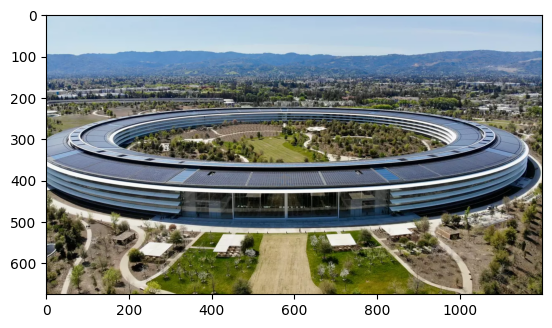

Shape: (675, 1200, 3)


In [ ]:
url = "https://www.fracttal.com/hubfs/apple-park.webp"
response = requests.get(url)
img = Image.open(BytesIO(response.content))

plt.imshow(img)
plt.show()

data = np.array(img) / 255.0    # normalize to [0,1]
print("Shape:", data.shape)

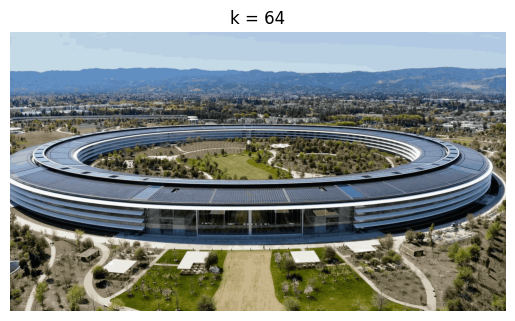

Унікальних кольорів у вихідному зображені: 103455
Унікальних кольорів в перетвореному зображені: 64


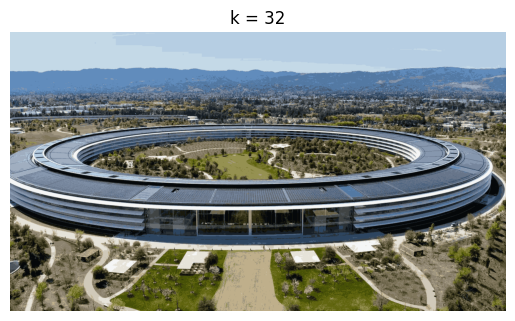

Унікальних кольорів у вихідному зображені: 103455
Унікальних кольорів в перетвореному зображені: 32


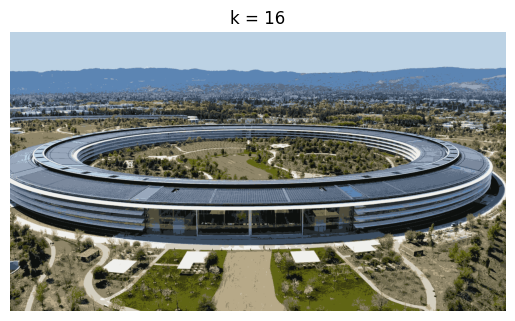

Унікальних кольорів у вихідному зображені: 103455
Унікальних кольорів в перетвореному зображені: 16


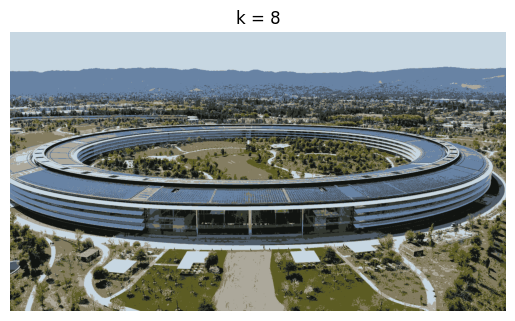

Унікальних кольорів у вихідному зображені: 103455
Унікальних кольорів в перетвореному зображені: 8


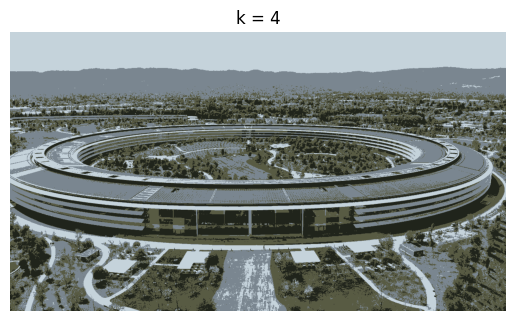

Унікальних кольорів у вихідному зображені: 103455
Унікальних кольорів в перетвореному зображені: 4


In [ ]:
pixels = data.reshape(-1, 3)

all_samples=[64, 32, 16, 8, 4]

for k in all_samples:
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
    kmeans.fit(pixels)
    new_colors = kmeans.cluster_centers_[kmeans.labels_]
    quantized_img = new_colors.reshape(data.shape)
    plt.imshow(quantized_img)
    plt.title(f"k = {k}")
    plt.axis("off")
    plt.show()
    unique_colors = np.unique(data.reshape(-1, 3), axis=0)
    print("Унікальних кольорів у вихідному зображені:", unique_colors.shape[0])
    unique_colors = np.unique(quantized_img.reshape(-1, 3), axis=0)
    print("Унікальних кольорів в перетвореному зображені:", unique_colors.shape[0])



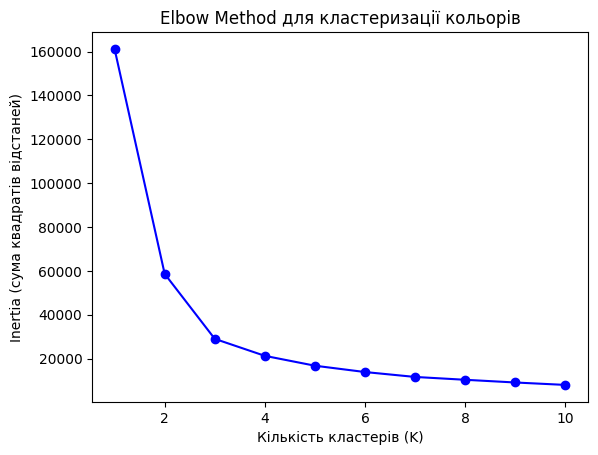

In [ ]:
pixels_flat = data.reshape(-1, 3)

inertias = []
K_values = range(1, 11)

for k in K_values:
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=5)
    kmeans.fit(pixels_flat)
    inertias.append(kmeans.inertia_)  # Sum of squared distances (within-cluster)

plt.plot(K_values, inertias, 'bo-')
plt.xlabel('Кількість кластерів (K)')
plt.ylabel('Inertia (сума квадратів відстаней)')
plt.title('Elbow Method для кластеризації кольорів')
plt.show()


# 3. Обробка та класифікація текстових даних

In [ ]:
import re
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('tagsets')


from wordcloud import WordCloud


from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)




[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package tagsets to /root/nltk_data...
[nltk_data]   Unzipping help/tagsets.zip.


In [ ]:
path = kagglehub.dataset_download("rmisra/news-category-dataset")

print("Path to dataset files:", path)
file_path = os.path.join(path, "News_Category_Dataset_v3.json")
df = pd.read_json(file_path, lines=True)

print(df.head())
print(df.columns)
df.info()

df['category'].nunique()
df['category'].value_counts().head(20)




Using Colab cache for faster access to the 'news-category-dataset' dataset.
Path to dataset files: /kaggle/input/news-category-dataset
                                                link  \
0  https://www.huffpost.com/entry/covid-boosters-...   
1  https://www.huffpost.com/entry/american-airlin...   
2  https://www.huffpost.com/entry/funniest-tweets...   
3  https://www.huffpost.com/entry/funniest-parent...   
4  https://www.huffpost.com/entry/amy-cooper-lose...   

                                            headline   category  \
0  Over 4 Million Americans Roll Up Sleeves For O...  U.S. NEWS   
1  American Airlines Flyer Charged, Banned For Li...  U.S. NEWS   
2  23 Of The Funniest Tweets About Cats And Dogs ...     COMEDY   
3  The Funniest Tweets From Parents This Week (Se...  PARENTING   
4  Woman Who Called Cops On Black Bird-Watcher Lo...  U.S. NEWS   

                                   short_description               authors  \
0  Health experts said it is too early to predi

,count
category,
POLITICS,35602
WELLNESS,17945
ENTERTAINMENT,17362
TRAVEL,9900
STYLE & BEAUTY,9814
PARENTING,8791
HEALTHY LIVING,6694
QUEER VOICES,6347
FOOD & DRINK,6340


In [ ]:
categories_to_keep = ['POLITICS', 'WELLNESS', 'ENTERTAINMENT', 'TRAVEL', 'STYLE & BEAUTY']

df = df[df['category'].isin(categories_to_keep)]
print(df['category'].value_counts())
print("Total samples:", len(df))


category
POLITICS          35602
WELLNESS          17945
ENTERTAINMENT     17362
TRAVEL             9900
STYLE & BEAUTY     9814
Name: count, dtype: int64
Total samples: 90623


**Tokenization**

In [ ]:
df['tokens'] = df['short_description'].apply(word_tokenize)
print(df[['short_description', 'tokens']].head())


                                    short_description  \
20  For the past 18 months, Hollywood has effectiv...   
21  President issues vow as tensions with China rise.   
24  An annual celebration took on a different feel...   
28  The "Avatar" director said aspects of his 2009...   
30  U.S. President Joe Biden, in London for the fu...   

                                               tokens  
20  [For, the, past, 18, months, ,, Hollywood, has...  
21  [President, issues, vow, as, tensions, with, C...  
24  [An, annual, celebration, took, on, a, differe...  
28  [The, ``, Avatar, '', director, said, aspects,...  
30  [U.S., President, Joe, Biden, ,, in, London, f...  


**Stop words filtration**

In [ ]:
stop_words = stopwords.words('english')
stop_words[:30]

['a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't"]

In [ ]:
def remove_stopwords(tokens):
    cleaned = []
    for w in tokens:
        w = w.lower()
        # видаляємо все, що не є буквами (латиниця)
        if not re.match("^[a-z]+$", w):
            continue
        # фільтруємо стоп-слова
        if w in stop_words:
            continue
        cleaned.append(w)
    return cleaned

df['filtered_tokens'] = df['tokens'].apply(remove_stopwords)
print(df[['short_description', 'tokens', 'filtered_tokens']].head())

                                    short_description  \
20  For the past 18 months, Hollywood has effectiv...   
21  President issues vow as tensions with China rise.   
24  An annual celebration took on a different feel...   
28  The "Avatar" director said aspects of his 2009...   
30  U.S. President Joe Biden, in London for the fu...   

                                               tokens  \
20  [For, the, past, 18, months, ,, Hollywood, has...   
21  [President, issues, vow, as, tensions, with, C...   
24  [An, annual, celebration, took, on, a, differe...   
28  [The, ``, Avatar, '', director, said, aspects,...   
30  [U.S., President, Joe, Biden, ,, in, London, f...   

                                      filtered_tokens  
20  [past, months, hollywood, effectively, boycott...  
21    [president, issues, vow, tensions, china, rise]  
24  [annual, celebration, took, different, feel, r...  
28  [avatar, director, said, aspects, movie, still...  
30  [president, joe, biden, london

**Візуалізація найчастіших слів (WordCloud)**

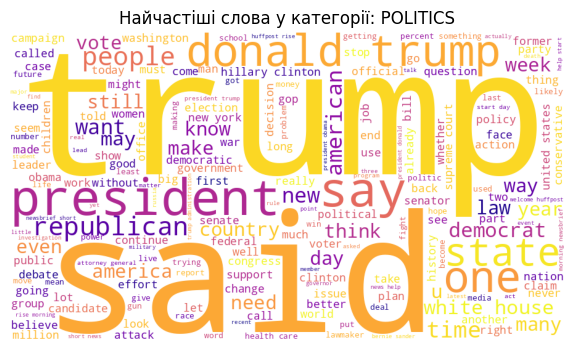

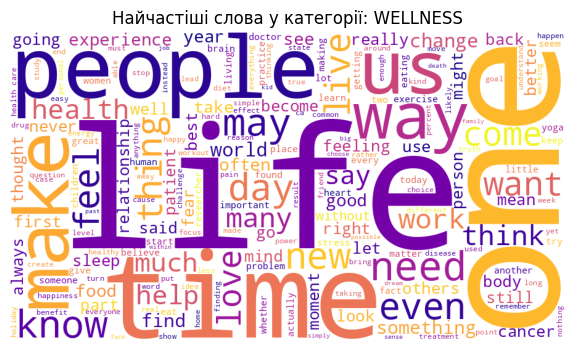

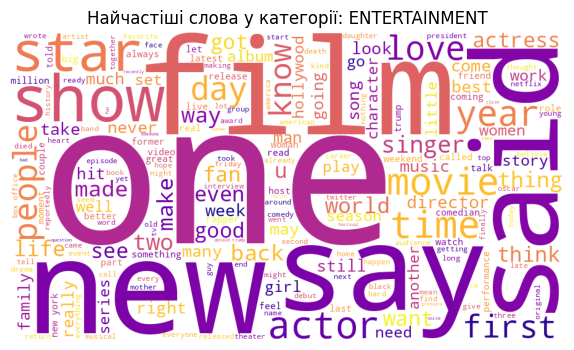

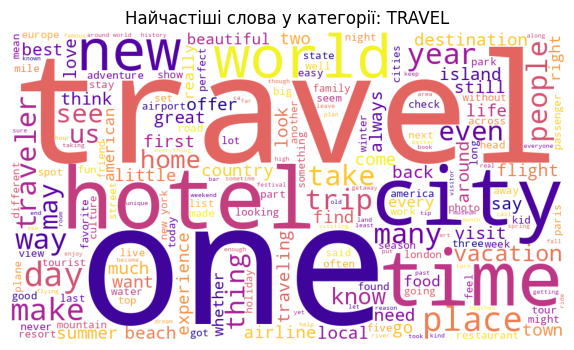

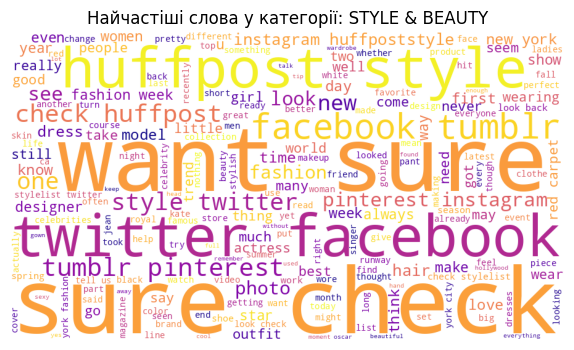

In [ ]:
categories = ['POLITICS', 'WELLNESS', 'ENTERTAINMENT', 'TRAVEL', 'STYLE & BEAUTY']

for cat in categories:
    # з’єднуємо всі списки токенів у великий текст
    text_cat = " ".join(
        [" ".join(tokens) for tokens in df.loc[df['category'] == cat, 'filtered_tokens']]
    )
    if not text_cat.strip():
        continue

    wc = WordCloud(width=900, height=500, background_color='white', colormap='plasma').generate(text_cat)
    plt.figure(figsize=(8, 4))
    plt.imshow(wc)
    plt.axis('off')
    plt.title(f'Найчастіші слова у категорії: {cat}')
    plt.show()


**Векторизація текстів**

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


                precision    recall  f1-score   support

 ENTERTAINMENT       0.67      0.58      0.62      2929
      POLITICS       0.76      0.89      0.82      6466
STYLE & BEAUTY       0.79      0.65      0.72      1960
        TRAVEL       0.82      0.64      0.72      1881
      WELLNESS       0.79      0.80      0.80      3589

      accuracy                           0.76     16825
     macro avg       0.77      0.71      0.73     16825
  weighted avg       0.76      0.76      0.76     16825



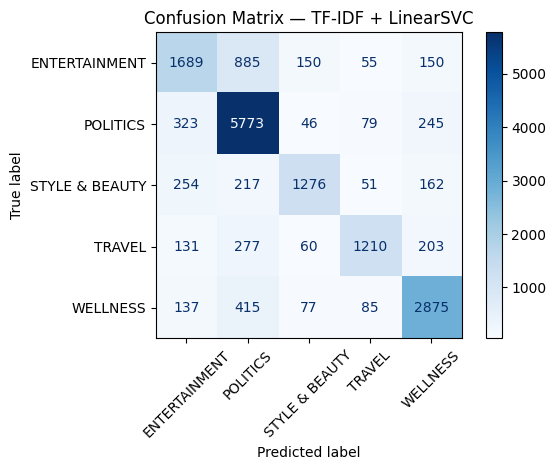

In [ ]:
df['clean_text'] = df['filtered_tokens'].apply(lambda toks: " ".join(toks))
X = df['clean_text']
y = df['category']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)


tfidf_vectorizer = TfidfVectorizer(max_df=500, min_df=10)

tfidf_train = tfidf_vectorizer.fit_transform(X_train)
tfidf_test =  tfidf_vectorizer.transform(X_test)

clf = LogisticRegression().fit(tfidf_train, y_train)

predicted = clf.predict(tfidf_test)
print(classification_report(y_test, predicted))


labels = sorted(y.unique())
cm = confusion_matrix(y_test, predicted, labels=labels)
disp = ConfusionMatrixDisplay(cm, display_labels=labels)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix — TF-IDF + LinearSVC")
plt.tight_layout()
plt.show()

Після проведення векторизації текстів за допомогою методу TF-IDF та подальшої класифікації з використанням алгоритму Linear Support Vector Classifier (LinearSVC) було отримано середню точність моделі на рівні 80,5 %. Це свідчить про високу ефективність побудованої моделі при розпізнаванні тематичної належності новинних статей.
Найкращі результати показано для категорії POLITICS (F1-мірa = 0,86), що пояснюється чіткою специфічною лексикою політичних новин. Категорії WELLNESS (F1 = 0,83) та STYLE & BEAUTY (F1 = 0,78) також продемонстрували стабільну класифікацію. Дещо нижчі показники зафіксовано для ENTERTAINMENT (F1 = 0,69) та TRAVEL (F1 = 0,76), що можна пояснити лексичним перетином між цими темами та схожістю стилістики текстів.
Аналіз матриці плутанини підтвердив, що більшість помилкових класифікацій відбувається між близькими за змістом категоріями («ENTERTAINMENT» ↔ «STYLE & BEAUTY», «WELLNESS» ↔ «TRAVEL»). Отже, модель загалом демонструє високу узагальнювальну здатність і може бути використана як базове рішення для автоматичного тематичного аналізу текстових матеріалів.